# E9.5 Trunk Neural Crest Dataset

Below, we replicate the scRNA-seq analysis for E9.5 day mouse trunk neural crest 10X scRNA-seq dataset published by [Soldatov et al. (2019)](https://science.sciencemag.org/content/sci/364/6444/eaas9536.full.pdf?ijkey=a4H.BHgtzk7Jg&keytype=ref&siteid=sci) in their paper __"Spatiotemporal structure of cell fate decisions in murine neural crest."__ 

## Table of Contents:
* ### [Data Pre-Processing](#1-bullet)
 * #### [Data Before Processing](#2-bullet)
 * #### [Data Normalization](#3-bullet)
 * #### [Highly-Variable Gene Selection](#4-bullet)
 
* ### [Data Visualization and Clustering](#5-bullet)
 * #### [Principal Component Analysis](#6-bullet)
 * #### [Computing the Neighborhood Graph and UMAPs](#7-bullet)
 * #### [Clustering](#8-bullet)
 * #### [Force Atlas Dimensionality Reduction](#8.5-bullet)
 * #### [Mapping Marker Genes](#8+-bullet)
 
* ### [Pseudotime Trajectory Analysis [Slingshot R]](#12-bullet)
* ### [Conclusion](#15-bullet)

We can begin with installing and importing the correct Python libraries for scRNA-seq data analysis.

In [ ]:
!pip install --quiet anndata2ri==1.0.2
!pip3 install --quiet rpy2==3.3.2
!pip3 install --quiet pandas
!pip3 install --quiet numpy
!pip install --quiet umap-learn==0.4.6
!pip install --quiet anndata==0.7.5
!pip3 install --quiet matplotlib
!pip3 install --quiet scikit-learn
!pip install --quiet scanpy==1.5.1
!pip3 install --quiet leidenalg==0.8.4
!pip install --quiet watermark==2.2.0

In [1]:
import warnings # ignores annoying warnings that pop up during import of packages
warnings.filterwarnings("ignore")

import numpy as np
import scanpy as sc
import scipy as sp
import pandas as pd
import seaborn as sb

import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
from matplotlib.axes._axes import _log as matplotlib_axes_logger
import matplotlib.font_manager
from matplotlib.figure import Figure
from matplotlib.backend_bases import FigureCanvasBase
import matplotlib.ticker as mtick
from matplotlib.backends.backend_pdf import PdfPages

from rpy2.robjects import pandas2ri
import anndata2ri
import rpy2.rinterface_lib.callbacks

ValueError: r_home is None. Try python -m rpy2.situation

Next, we need to set up the interface between Python and R (via the `rpy2` and `anndata2ri` packages).

In [ ]:
# We're going to change some of the parameters for warning/error messages in several packages. 
import logging

# This ignores an annoying matplotlib error that comes up with the colors on a plot.
matplotlib_axes_logger.setLevel('ERROR')

# Ignore R warning messages
# Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

# Set on Scanpy's verbose output
sc.settings.verbosity = 3   # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)

# Set directories for the data, results, and figures. SPECIFY AS APPROPRIATE
data_path = '/content/'

Finally, we need to import the Python module written as a supplement for scRNA-seq analysis by Scanpy.

In [ ]:
# Get the module.py file from GitHub
user = "nkanrar"
repo = "motifs"
pyfile = "module.py"

url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{pyfile}"
!wget --no-cache --backups=1 {url}

# Read the file in
with open(pyfile, 'r') as f:
    f.read()

# Import the module
import module as md

--2022-03-07 06:02:50--  https://raw.githubusercontent.com/nkanrar/motifs/main/module.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41408 (40K) [text/plain]
Failed to rename module.py to module.py.1: (2) No such file or directory
Saving to: ‘module.py’

module.py           100%[===================>]  40.44K  --.-KB/s    in 0.006s  

2022-03-07 06:02:50 (7.12 MB/s) - ‘module.py’ saved [41408/41408]



In [ ]:
%%R
install.packages("data.table", type = "source", repos = "https://Rdatatable.gitlab.io/data.table")
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install(c("DelayedMatrixStats", "slingshot"), Ncpus = 2)

In [ ]:
%%R
library(DelayedMatrixStats)
library(slingshot)

## Data Pre-Processing <a class="anchor" id="1-bullet"></a>

Soldatov et al. upload their gene expression matrix as a txt file, available at [GSE129114](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE129114). They do not provide metadata but provide marker genes to identify cell types.

We can read this txt file into Scanpy to create an AnnData object. 

In [ ]:
!wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE129nnn/GSE129114/suppl/GSE129114_E9.5_trunk_Wnt1_counts.txt.gz

--2022-03-07 06:03:36--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE129nnn/GSE129114/suppl/GSE129114_E9.5_trunk_Wnt1_counts.txt.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 165.112.9.230, 130.14.250.7, 2607:f220:41e:250::12, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|165.112.9.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11496681 (11M) [application/x-gzip]
Saving to: ‘GSE129114_E9.5_trunk_Wnt1_counts.txt.gz’

GSE129114_E9.5_trun 100%[===================>]  10.96M  16.7MB/s    in 0.7s    

2022-03-07 06:03:37 (16.7 MB/s) - ‘GSE129114_E9.5_trunk_Wnt1_counts.txt.gz’ saved [11496681/11496681]



In [ ]:
!gunzip GSE129114_E9.5_trunk_Wnt1_counts.txt.gz

In [ ]:
# We create the AnnData object by uploading the gene expression matrix.
file = data_path +'GSE129114_E9.5_trunk_Wnt1_counts.txt' # file that stores the data, a csv for this paper
adata = sc.read(file).T

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [ ]:
adata

AnnData object with n_obs × n_vars = 1152 × 23420

### Data Before Processing <a class="anchor" id="2-bullet"></a>

We can do exploratory data analysis before we actually perform quality control.

normalizing counts per cell
    finished (0:00:00)


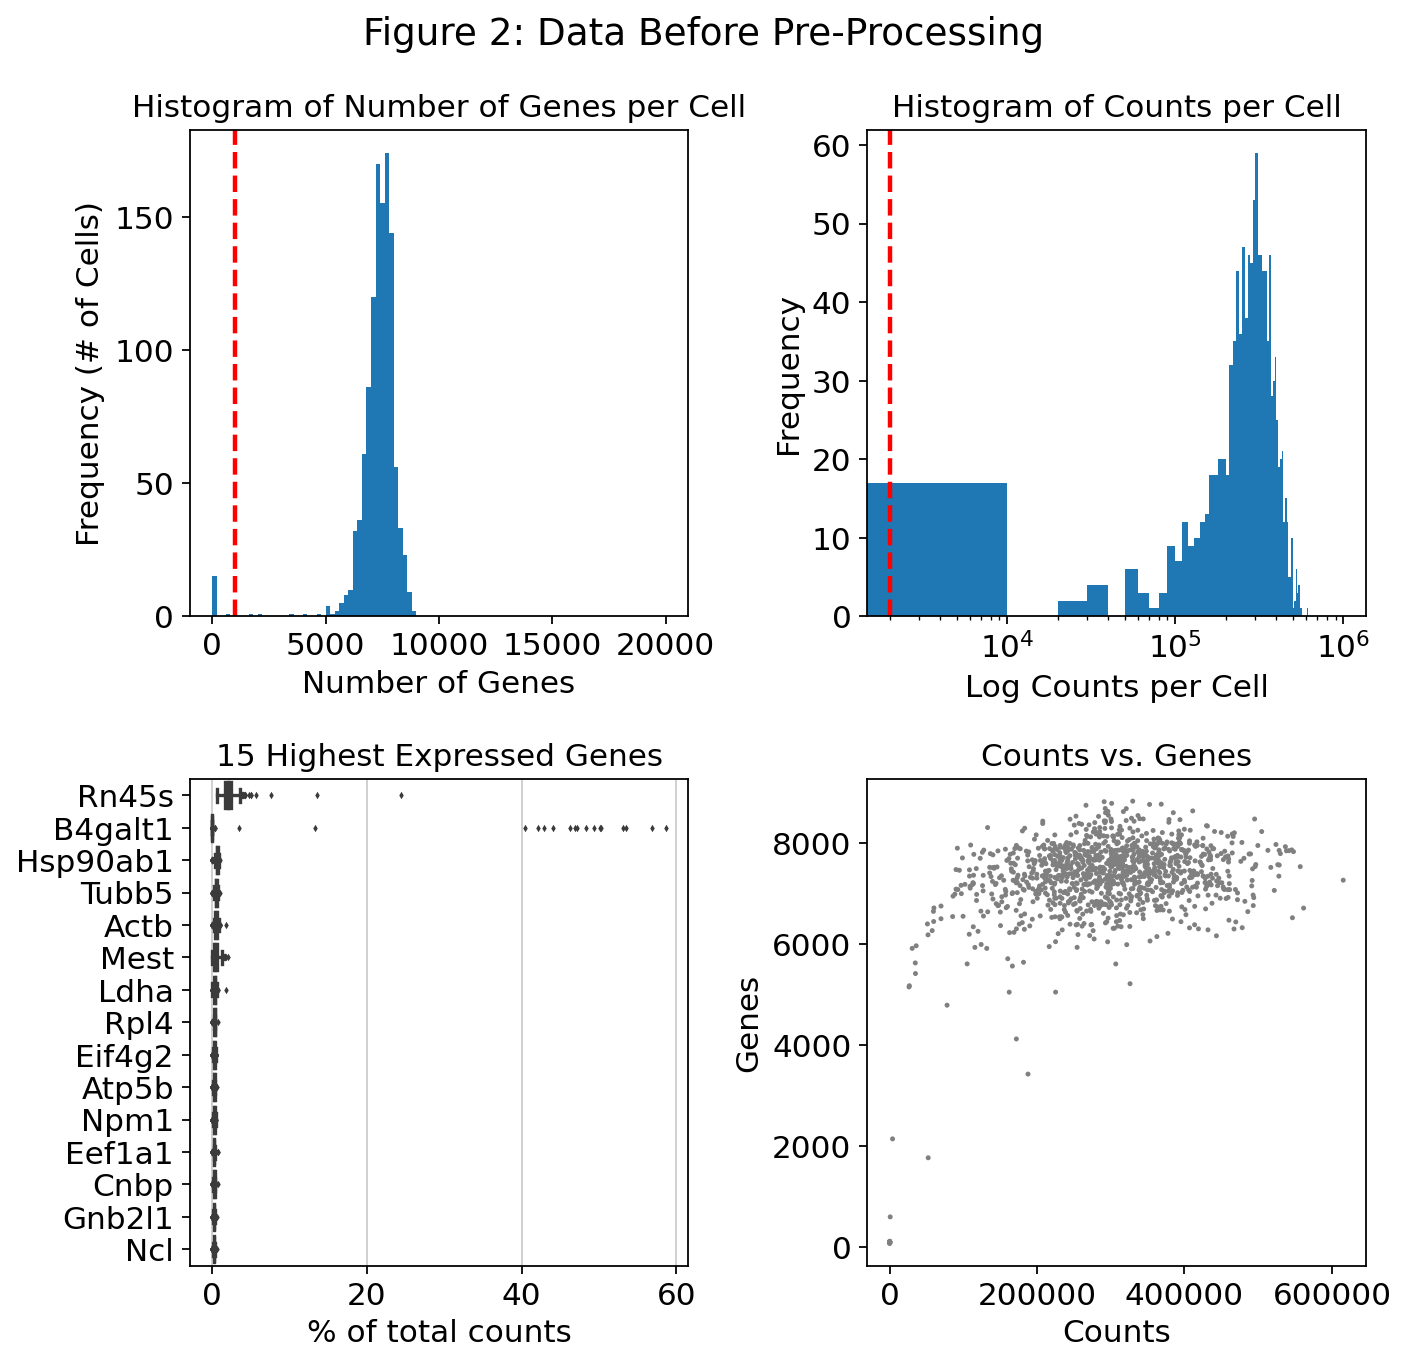

CPU times: user 2.81 s, sys: 426 ms, total: 3.23 s
Wall time: 2.91 s


In [ ]:
%%time

# Below, we display cells with genes/cell and counts/cell, for genes that 
# have at least one 1 count in any cell. 
sc.pp.filter_cells(adata, min_genes=0)
sc.pp.filter_genes(adata, min_cells=0)

# Set annotations to the AnnData object for total counts, cells per gene, and mitochondrial genes
X = np.matrix(adata.X)
adata.obs['n_total_counts_per_cell'] = (X.sum(axis=1).A1)
adata.var['n_cells_per_gene'] = X.astype(bool).astype(int).sum(axis=0).A1
adata.obs['n_genes_per_cell'] = X.astype(bool).astype(int).sum(axis=1).A1

# Make plots to visualize data quality.

pre_processed = md.vis_pre_processing(adata, genes_range=(0, 20000),
    counts_range=(0, 1e6),title='Figure 2: Data Before Pre-Processing',
                                     genes_threshold = 1000, counts_threshold=2000)

In [ ]:
avg_genes = int(np.average(adata.obs['n_genes_per_cell']))
avg_counts = int(np.average(adata.obs['n_total_counts_per_cell']))

print('The average number of genes per cell is ' + str(avg_genes) 
      + ' and the average number of counts per cell is ' 
      + str(avg_counts))

The average number of genes per cell is 7276 and the average number of counts per cell is 294911


The plots above allow us to visualize parameters for our data set, including the number of unique cells and genes captured in the data set, and the distributions of the total number of counts per cell, the total numbers of genes per cell, and the total number of cells per gene.

The authors of the paper use a minimum gene filter of 3,000 genes/cell. We will also use this filter. The authors also apply a filter on genes such that only genes expressed in at least 5 cells are kept. We apply this filter on genes.

filtered out 18 cells that have less than 3000 genes expressed
filtered out 7675 genes that are detected in less than 5 cells


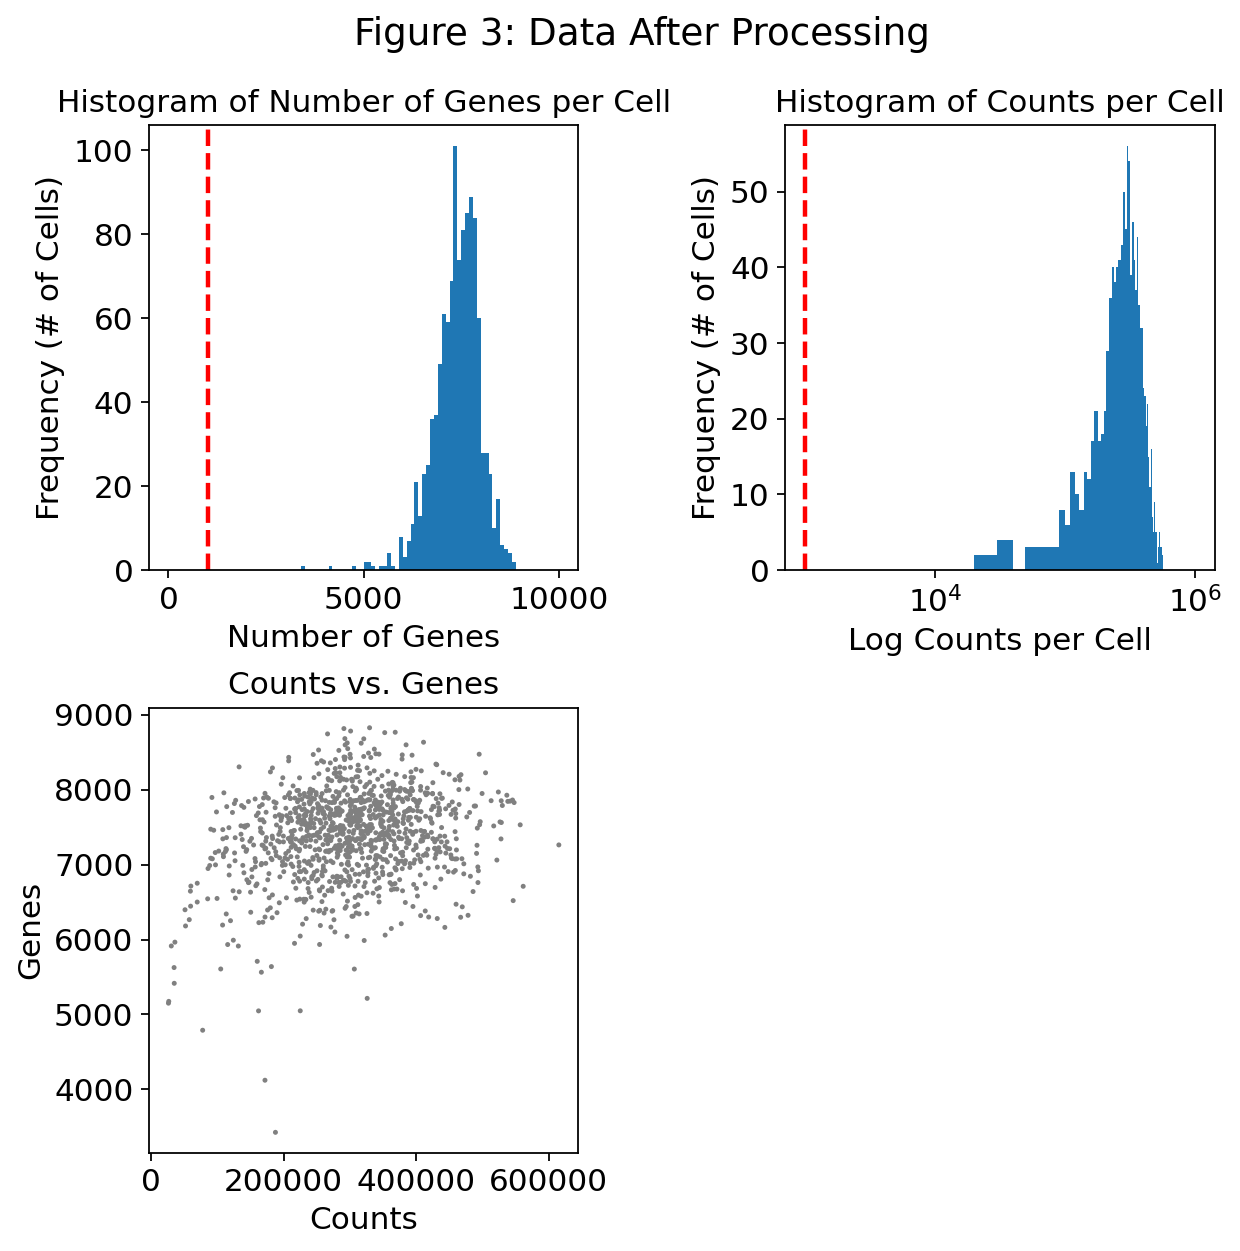

CPU times: user 1.85 s, sys: 292 ms, total: 2.14 s
Wall time: 1.91 s


In [ ]:
%%time
# Filter cells based on genes/cell, and genes based on the number of cells expressing them
adata = md.filter_data(adata, min_counts=0, min_genes=3000, min_cells=5)

# Plot data post-processing
post_processing = md.vis_post_processing(adata, genes_range=(0, 10000),
    counts_range=(1e4, 1e6),title='Figure 3: Data After Processing',
                                     genes_threshold = 1000, counts_threshold=1000)

### Data Normalization <a class="anchor" id="3-bullet"></a>

We normalize the data below.

In [ ]:
%%time

# Save data prior to normalizing, for downstream analysis.
pre_norm = adata.copy()

# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# We set the raw attribute of our AnnData object as the normalized count matrix. 
adata.raw=adata

normalizing counts per cell
    finished (0:00:00)
CPU times: user 361 ms, sys: 4.67 ms, total: 365 ms
Wall time: 372 ms


For our atlas of multiple datasets, we can save this normalized data that contains all genes that have non-zero expression in a minimum number of cells. We will save the entire AnnData object.

### Highly-Variable Gene Selection <a class="anchor" id="4-bullet"></a>

We select the top 4,000 highly variable genes. Soldatov et. al do something slightly different, by detecting the genes with higest disperson.

Subsequently, we filter out all genes except our highly variable genes, thus only keeping genes that are informative of the heterogeneity of our data. This "dense" matrix is necessary for downstream operations because a larger matrix is more computationally expensive.

In [ ]:
%%time
# Compute HVGs
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=4000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
CPU times: user 842 ms, sys: 16.9 ms, total: 859 ms
Wall time: 867 ms


Below, we select for genes of interest: Bmp, Wnt, Notch, Eph, Fgfr, Splice SRSF, and LPA pathway genes, and marker genes specified in the paper. Note that these genes we select pass our quality-control filters above. Since these genes may not necessarily be highly-variable, we "force" our gene expression matrix to keep our genes of interest for our downstream analysis.

Next, we regress our data on the total number of counts per cell. We then scale our data set by centering each gene's expression with zero mean and unit variance, and filter out any genes whose standard deviation for expression is greater than 10. 

In [ ]:
%%time
# get_genes returns a list of genes that are actually in the filtered data matrix (genes that pass the QC filters)
wnt_ligands = md.get_genes(adata, md.wnts)
wnt_receptors = md.get_genes(adata, md.wntr)
bmp_ligands = md.get_genes(adata, md.bmps)
bmp_receptors = md.get_genes(adata, md.bmpr)
notch = md.get_genes(adata, md.notch)
eph_receptors = md.get_genes(adata, md.ephr)
eph_ligands = md.get_genes(adata, md.ephl)
fgfr = md.get_genes(adata, md.fgfr)
splice_srsf = md.get_genes(adata, md.splice_srsf)
lpa = md.get_genes(adata, md.lpa)

# Get this from the paper!
markers = ["Gapdh", "Malat1", 
           "Zic3", "Olig3", "Bmp6", "Lmx1a", 
           "Dlx5", "Pak3", "Hapln1", 
           "Phox2b", "Ascl1", "Lcp2", 
           "Plp1", "Zfp488", "Nkain4", "Egflam", "Mstn", 
           "Prrx1", "Meox1", "Twist1", "Etv4",
           "Neurog2", "Pou4f1", "Neurog1", "Neurod4", "Neurod1", "Eya2", "Isl1", "Six1"
          ]

pathways = {'Wnt Ligands': wnt_ligands, 'Wnt Receptors': wnt_receptors, 'BMP Ligands': bmp_ligands,
           'BMP Receptors': bmp_receptors, 'Notch': notch, 'Eph Receptors': eph_receptors, 
           'Eph ligands': eph_ligands, 'Eph-Ephrin': eph_receptors + eph_ligands, 'Fgfr': fgfr, 'Splice SRSF': splice_srsf,
           'LPA': lpa}

all_genes = wnt_ligands + wnt_receptors + bmp_ligands + bmp_receptors + notch + markers + eph_receptors + eph_ligands + fgfr + splice_srsf + lpa

adata = md.merge_genes(adata, all_genes)
sc.pp.regress_out(adata, ['n_total_counts_per_cell'])
sc.pp.scale(adata)

regressing out ['n_total_counts_per_cell']
    finished (0:00:34)
CPU times: user 38.5 s, sys: 252 ms, total: 38.7 s
Wall time: 39.4 s


In [ ]:
adata

AnnData object with n_obs × n_vars = 1134 × 14128
    obs: 'n_genes', 'n_total_counts_per_cell', 'n_genes_per_cell', 'n_counts'
    var: 'n_cells', 'n_cells_per_gene', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p'

## Data Visualization and Clustering <a class="anchor" id="5-bullet"></a>

### Principal component analysis <a class="anchor" id="6-bullet"></a>

We perform principal component analysis on the processed data set. This transforms the data to a new linear space and defines a "best-fitting line" for multi-dimensional data. Below, we also plot the variance ratio of the principal components to determine the minimum number of principal components we must select for dimensionality reduction.

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


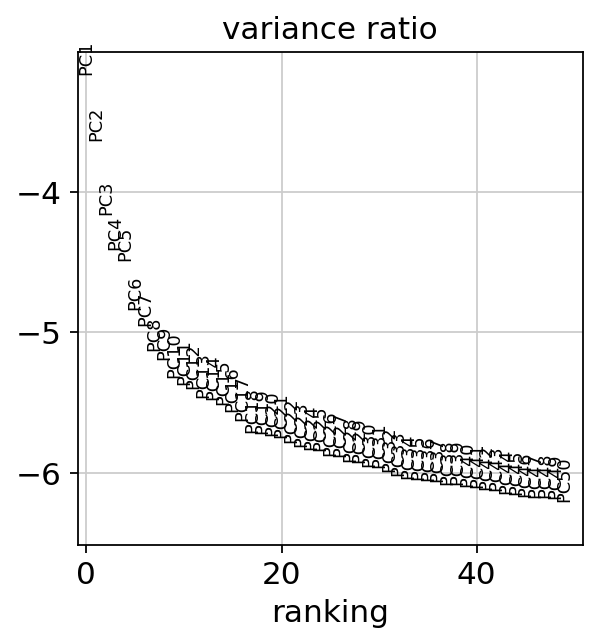

In [ ]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)

sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

### Computing the Neighborhood Graph and UMAPs <a class="anchor" id="7-bullet"></a>

We can compute a neighborhood graph of cells using a PCA representation of our data matrix. We can then use UMAPs or the Force Atlas algorithm for dimensionality reduction and visualization. We can appropriately adjust the number of principal components we select based on the above variance ratio plot.

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)

sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


### Clustering <a class="anchor" id="8-bullet"></a>

We then want to group the cells based on similarity of gene expression. These smaller clusters can inform us of the heterogeneity within the cell types they make up.

In [ ]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [ ]:
markers_in_data = []
for i in markers:
    if i in adata.var.index:
        markers_in_data.append(i)

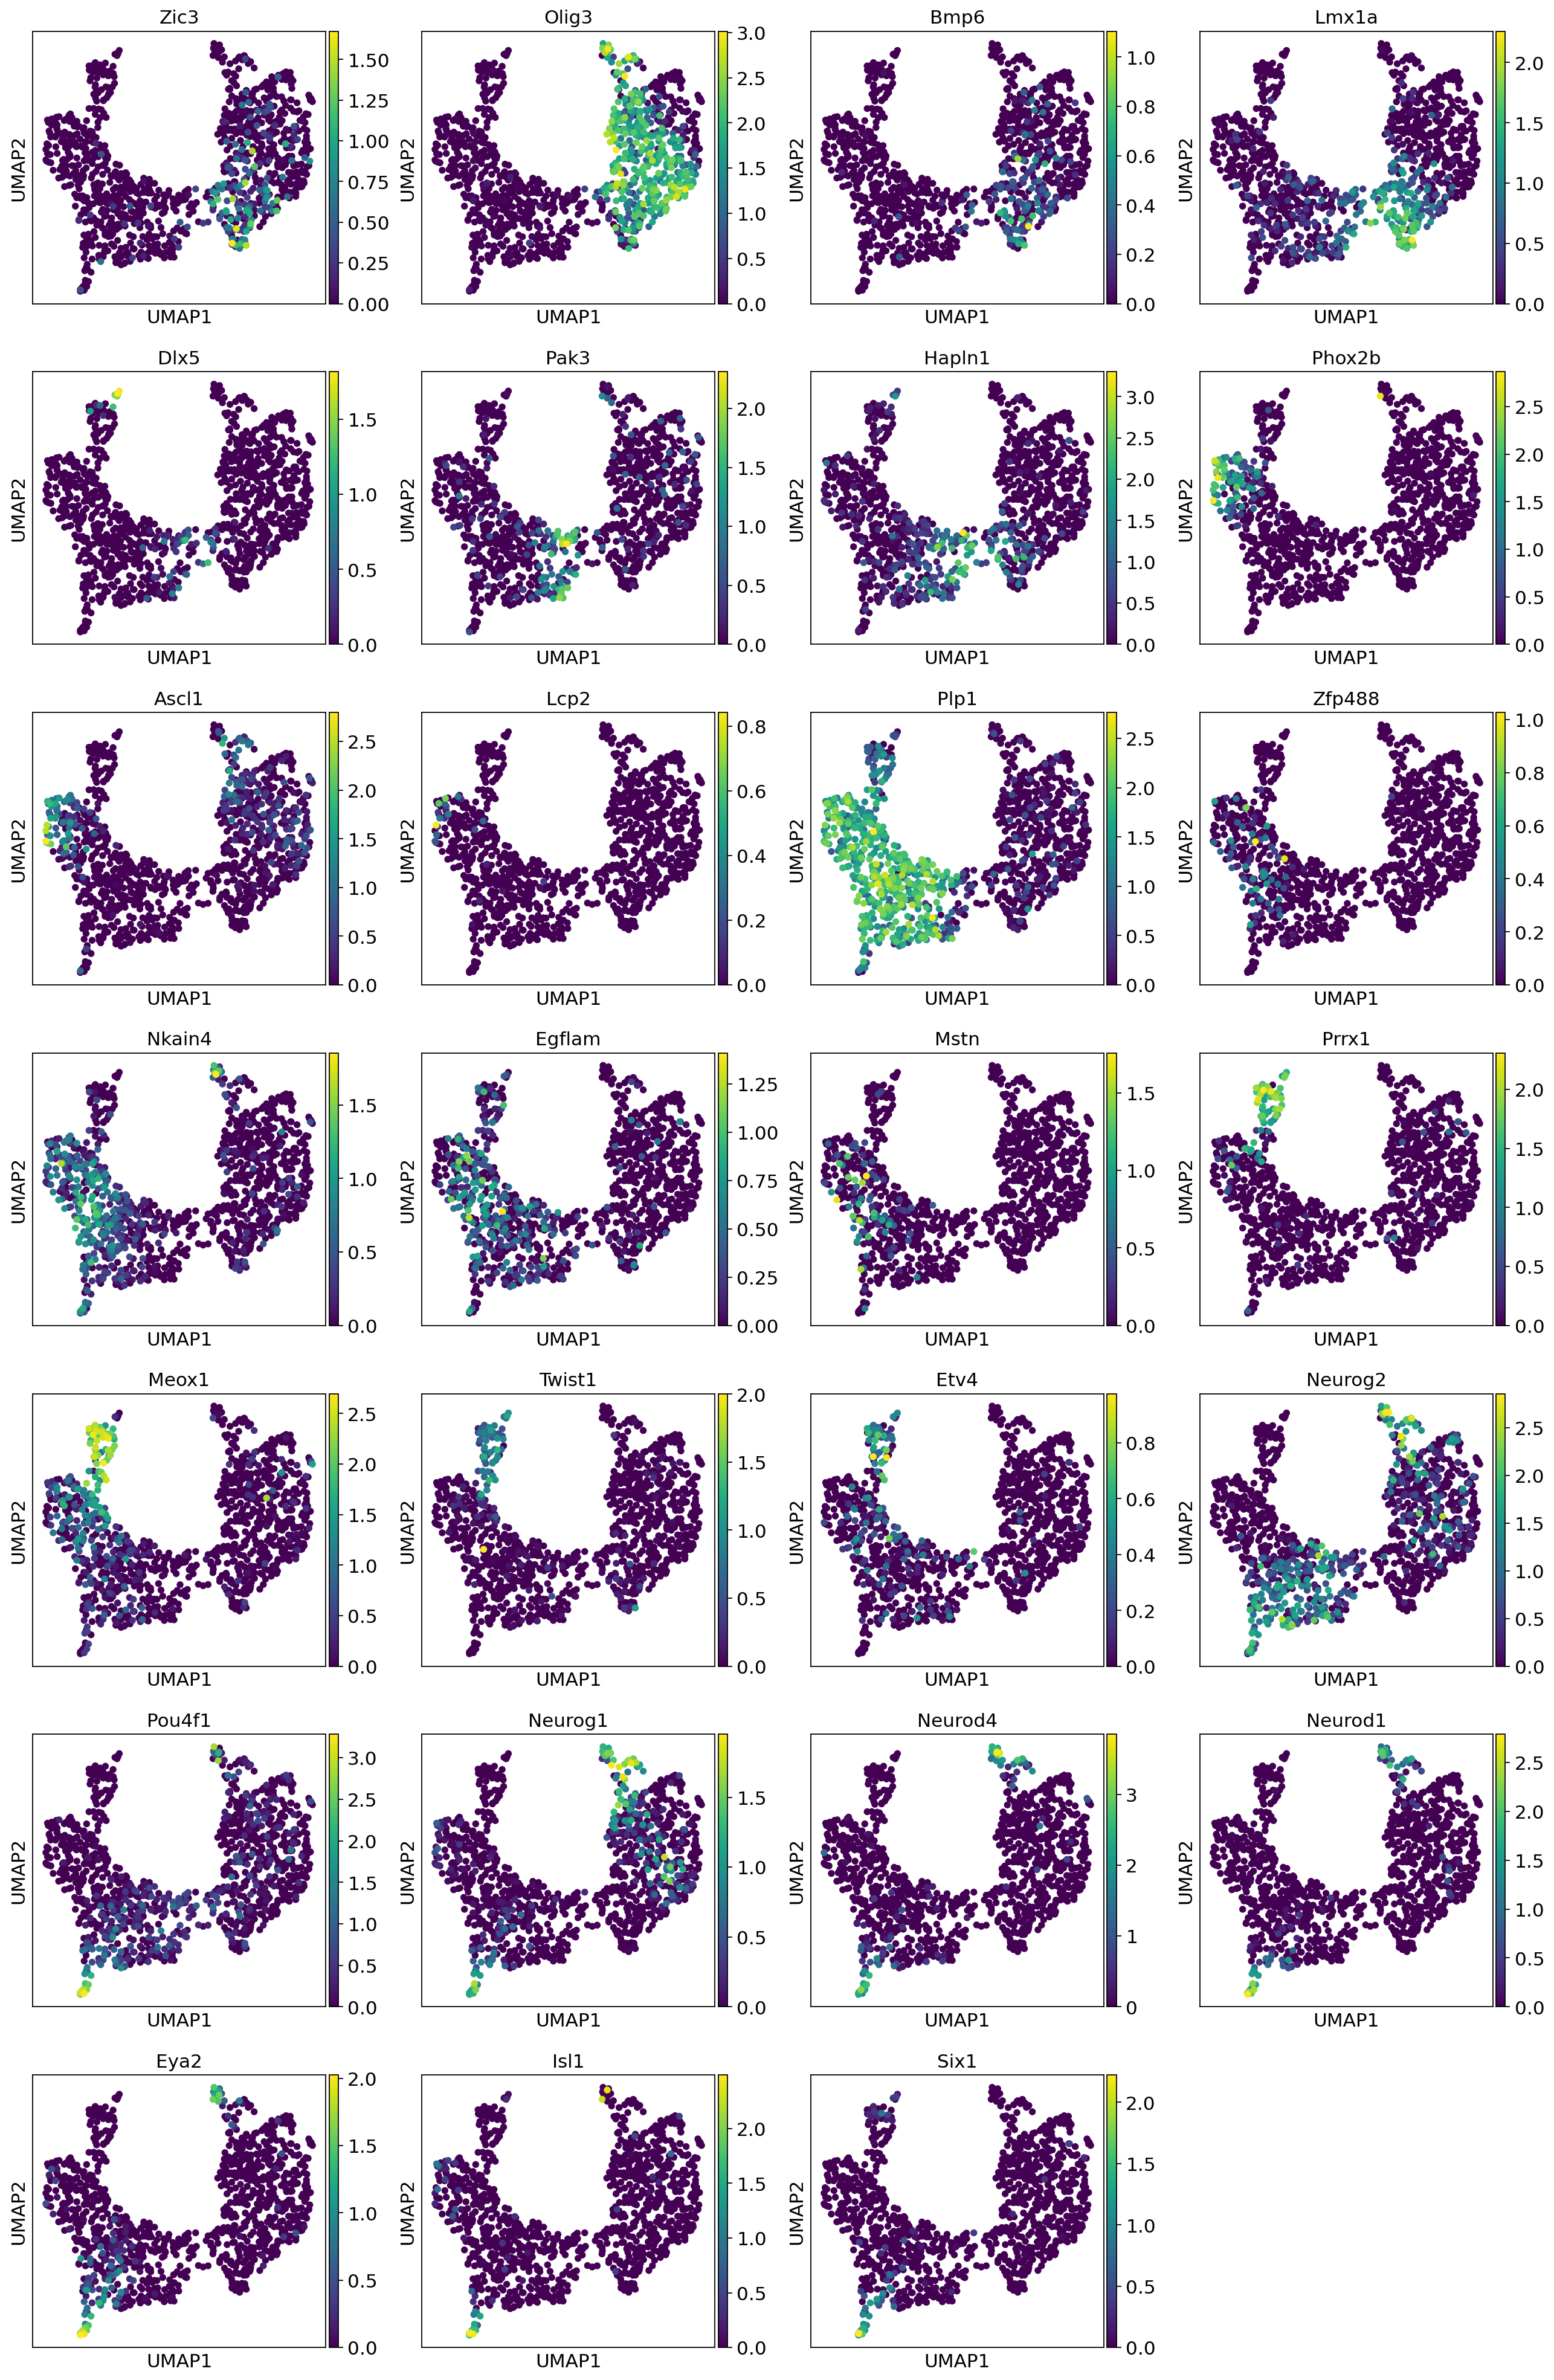

In [ ]:
sc.pl.umap(adata, color=markers[2:])

### Force Atlas Dimensionality Reduction <a class="anchor" id="8.5-bullet"></a>

The UMAP plots are fairly dispersed in terms of shape. We can try another visualization for representing the data, with force-directed plots using the Force Atlas Python package.

In [ ]:
sc.tl.draw_graph(adata)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:04)


To evaluate whether the results are reasonable, we can plot marker gene expression and compare to the authors' results.

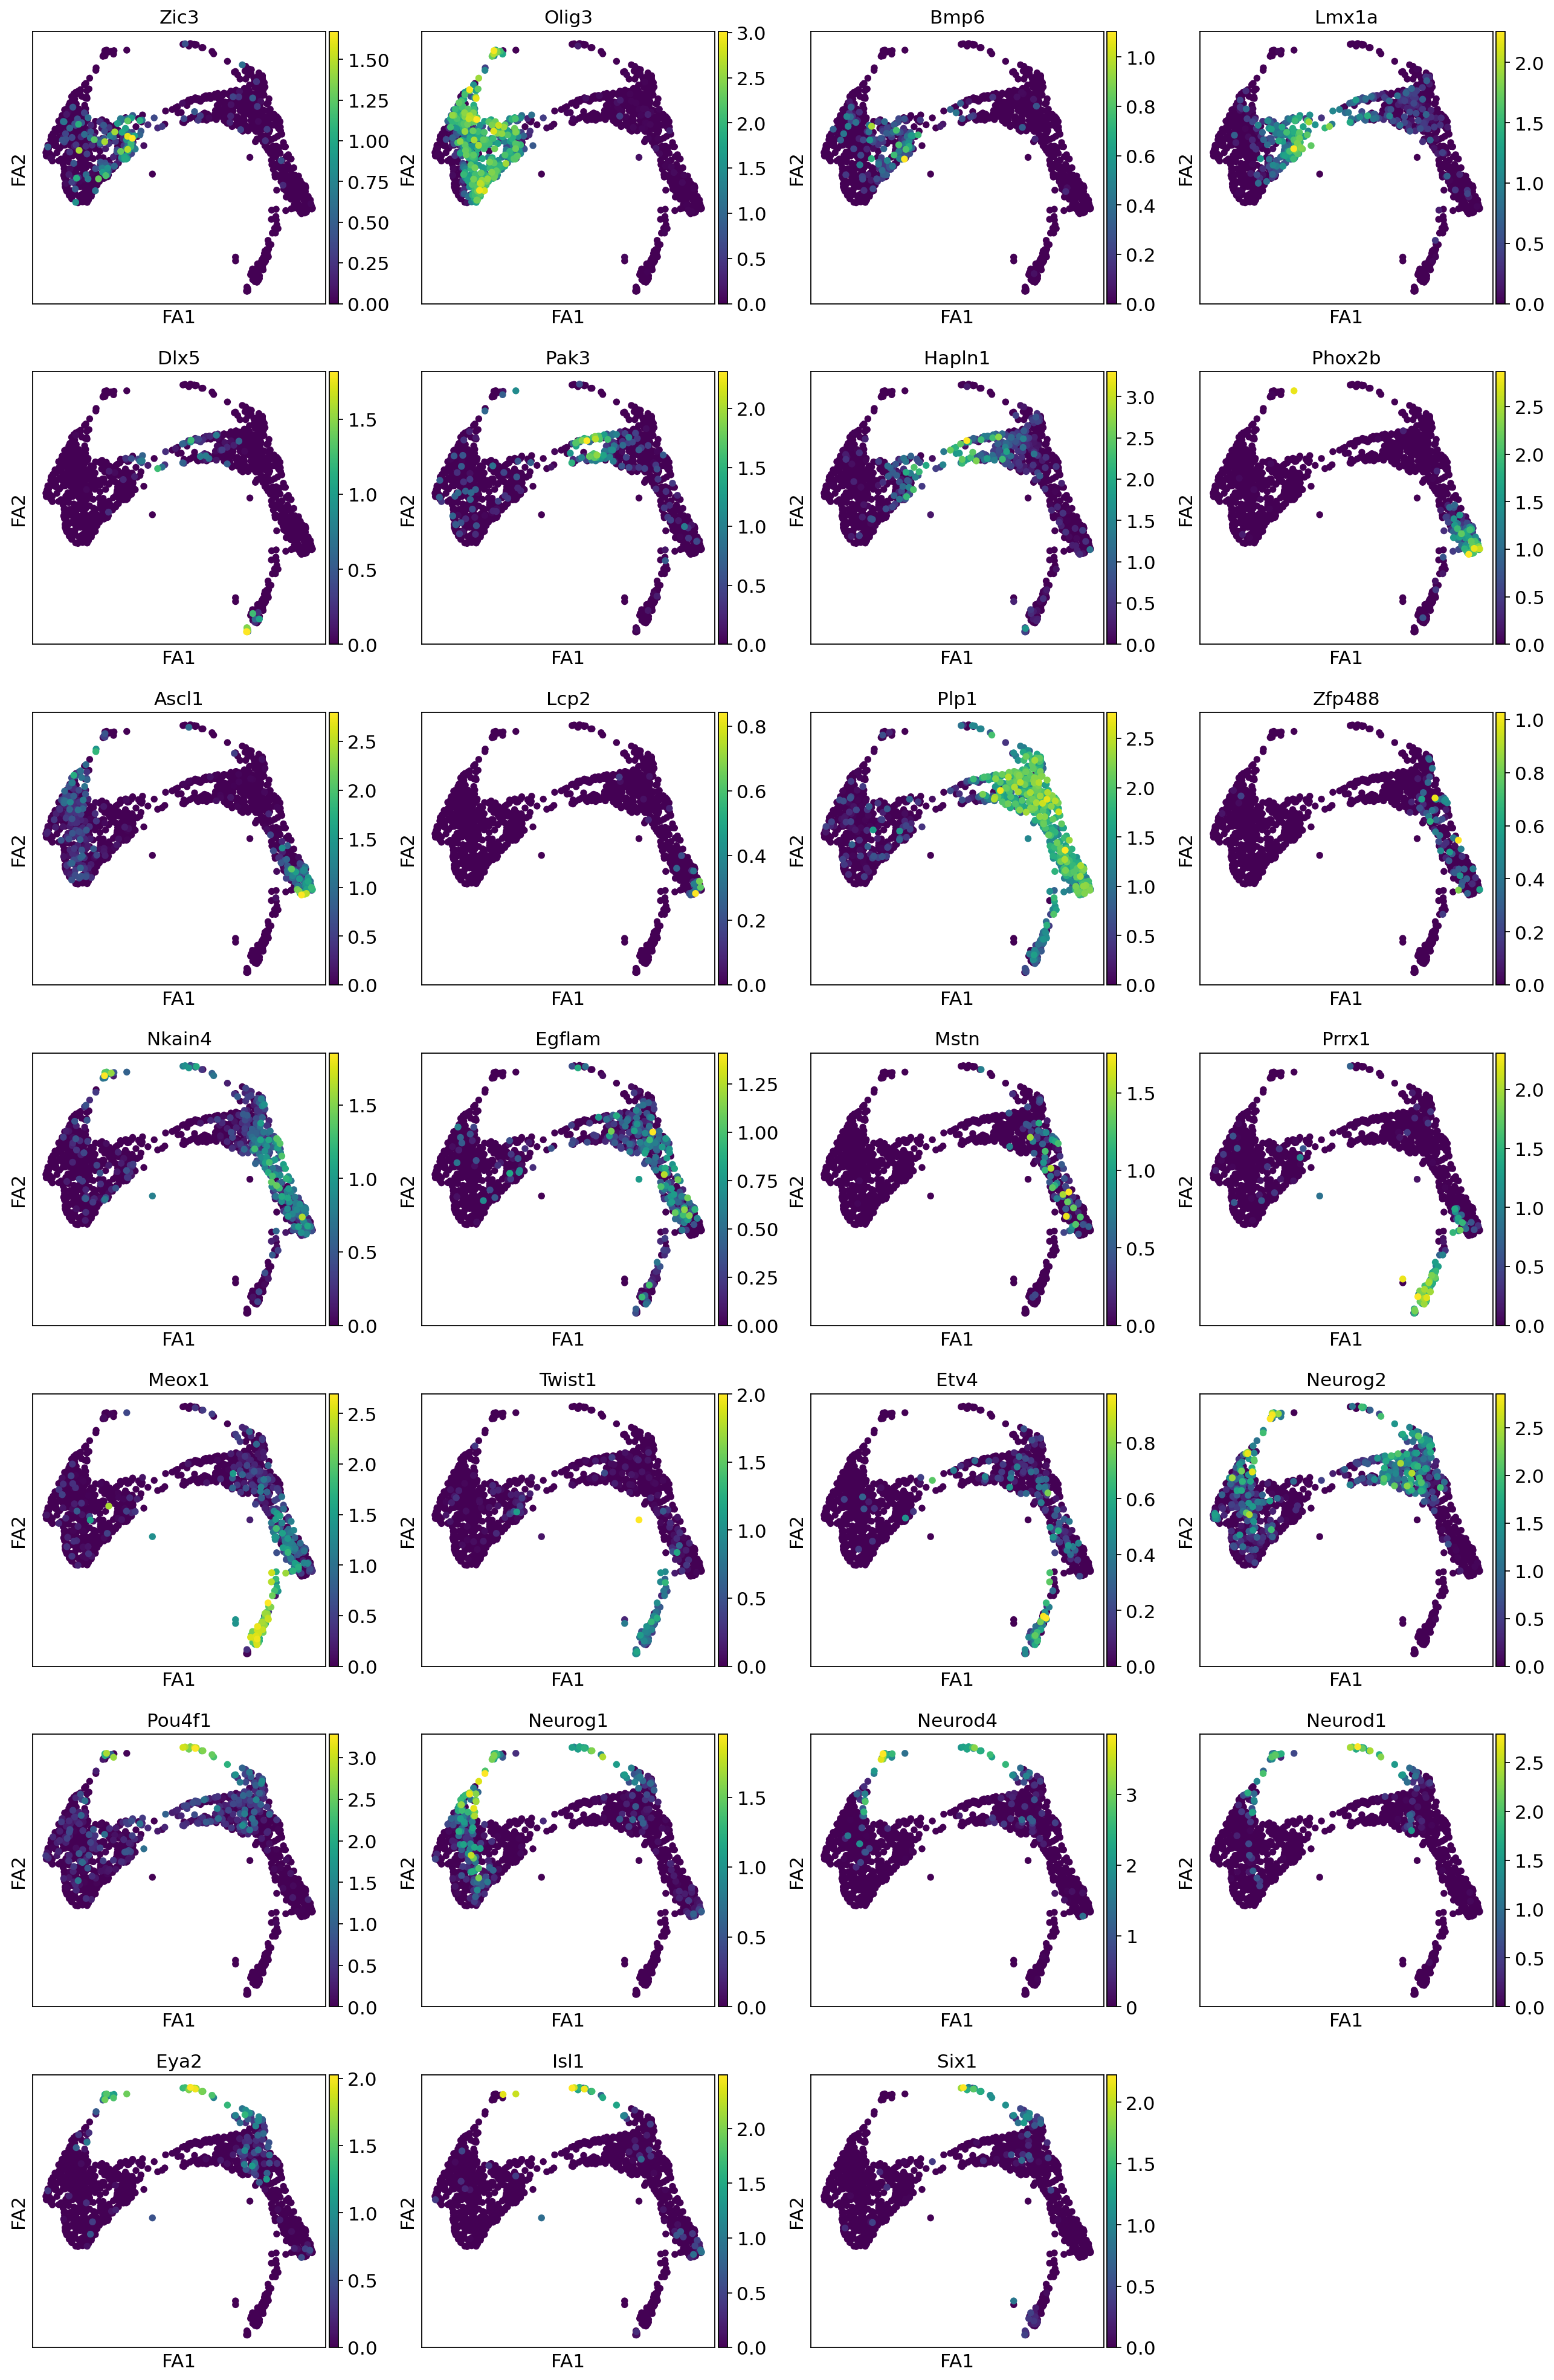

In [ ]:
sc.pl.draw_graph(adata, color=markers[2:])

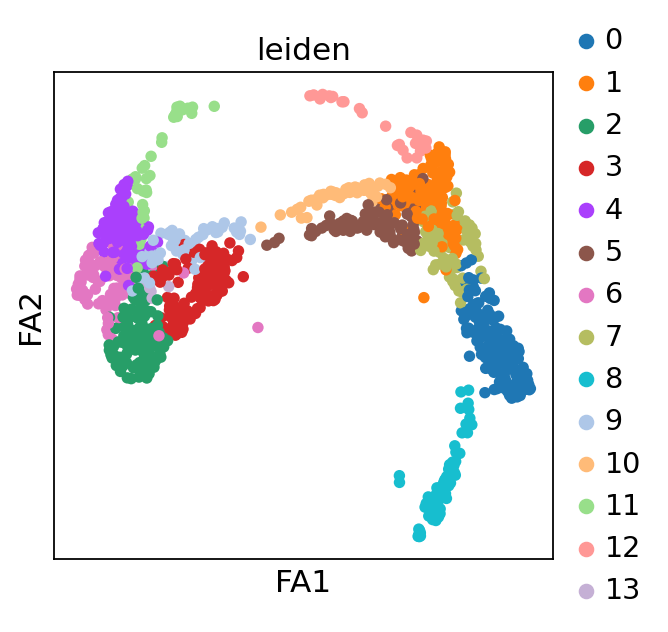

In [ ]:
sc.pl.draw_graph(adata, color="leiden")

### Mapping Marker Genes <a class="anchor" id="8+-bullet"></a>

The authors do not provide metadata files for mapping cell type, since some intermediate cells in the neural crest trajectory are difficult to characterize as a particular cell type. Instead, they provide marker genes to characterize cells with a "definitive" cell type. Below, I give each Leiden cluster a score for expression of the marker genes that characterize each cell type.

In [ ]:
marker_genes = {
    "Premigratory": ['Zic3', 'Olig3', 'Bmp6', 'Lmx1a'],
    "Delamination": ['Dlx5', 'Pak3', 'Hapln1'],
    "Autonomic":    ['Phox2b', 'Ascl1', 'Lcp2'],
    "Mesenchyme":   ['Prrx1', 'Meox1', 'Twist1', 'Etv4'],
    "Glia":         ['Plp1', 'Zfp488', 'Nkain4', 'Egflam', 'Mstn'],
    "Sensory":      ['Neurog2', 'Pou4f1', 'Neurog1', 'Neurod4', 'Neurod1', 'Eya2', 'Isl1','Six1']
}
cell_type_df = md.evaluate_partition(adata, marker_genes)

cell_type_df

0         1        10        11        12        13  \
Premigratory -0.438727 -0.370694 -0.129510  0.028972 -0.409162 -0.466468   
Delamination -0.242027 -0.072795  1.800520 -0.215322 -0.247769 -0.171902   
Autonomic     1.111082 -0.251611 -0.233128  0.196747 -0.204507 -0.093511   
Mesenchyme    0.181356 -0.129229 -0.217862 -0.314372 -0.202491 -0.158817   
Glia          0.727807  0.340713 -0.148789 -0.231145  0.164758 -0.416622   
Sensory      -0.256548 -0.018968 -0.093640  1.618218  3.549958 -0.193237   

                     2         3         4         5         6         7  \
Premigratory  0.059554  1.287196  0.128431 -0.174929 -0.260239 -0.375798   
Delamination -0.251480 -0.068452 -0.267168  0.840423 -0.240558 -0.213460   
Autonomic    -0.092551 -0.242796 -0.029223 -0.261331 -0.151431 -0.235658   
Mesenchyme   -0.310515 -0.233963 -0.301609 -0.213117 -0.244735 -0.193062   
Glia         -0.442972 -0.377459 -0.405532 -0.028213 -0.436946  1.099908   
Sensory      -0.151764 -0.241795 -0.107255  0.040515 -0.174601 -0.032521   

                     8         9  
Premigratory -0.442052  0.845936  
Delamination  0.214240  0.096227  
Autonomic    -0.233514 -0.214609  
Mesenchyme    2.827615 -0.267232  
Glia         -0.149302 -0.434719  
Sensory      -0.263325 -0.189065

Using the above scores, we can manually map cell type onto Leiden clusters. 

... storing 'cell_type' as categorical


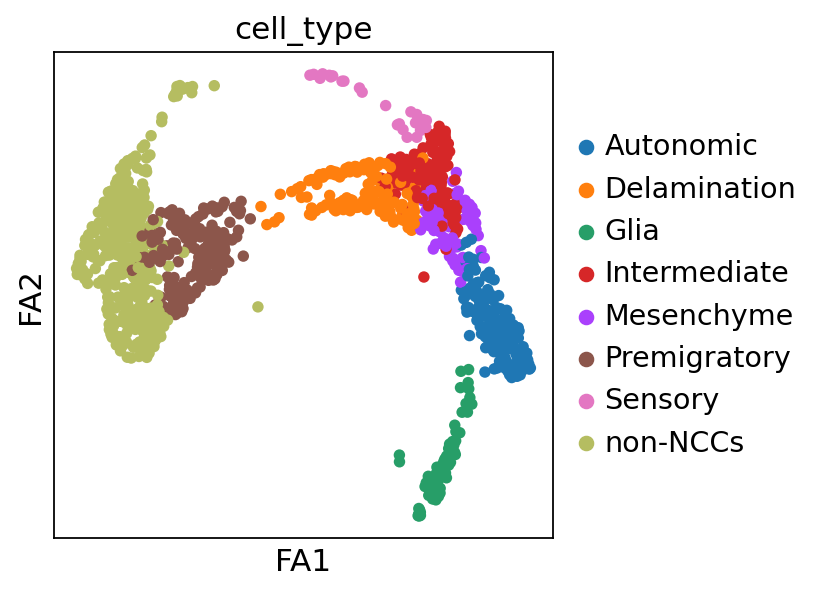

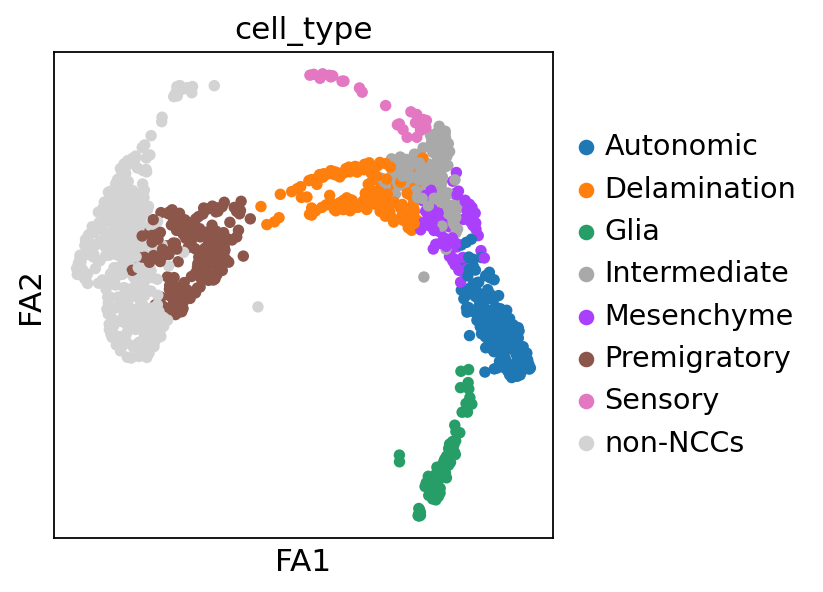

In [ ]:
ncc_labels = {
        "0": "Autonomic",
        "10": "Delamination",
        "11": "non-NCCs", # Technically sensory, but these cells aren't included in the authors' lineages
        "12": "Sensory",
        "3": "Premigratory",
        "5": "Delamination",
        "7": "Mesenchyme",
        "8": "Glia",
        "9": "Premigratory",
        "1": "Intermediate",
        "2": "non-NCCs",
        "4": "non-NCCs",
        "6": "non-NCCs",
        "13": "non-NCCs",
      }

adata.obs['cell_type'] = adata.obs['leiden'].replace(ncc_labels)

sc.pl.draw_graph(adata, color = "cell_type", show=False)

# Let's label the intermediate and non-neural crest cells with different tones of greys.
adata.uns["cell_type_colors"][-1] = "#d3d3d3"
adata.uns["cell_type_colors"][3] = "#a9a9a9"

sc.pl.draw_graph(adata, color = "cell_type")

We are only interested in the neural crest cells, so we can subset these into a separate AnnData object.

In [ ]:
adata_nccs = adata[~adata.obs["cell_type"].isin(["non-NCCs"]),:].copy()

adata_nccs

AnnData object with n_obs × n_vars = 760 × 14128
    obs: 'n_genes', 'n_total_counts_per_cell', 'n_genes_per_cell', 'n_counts', 'leiden', 'cell_type'
    var: 'n_cells', 'n_cells_per_gene', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'draw_graph', 'leiden_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap', 'X_draw_graph_fa'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

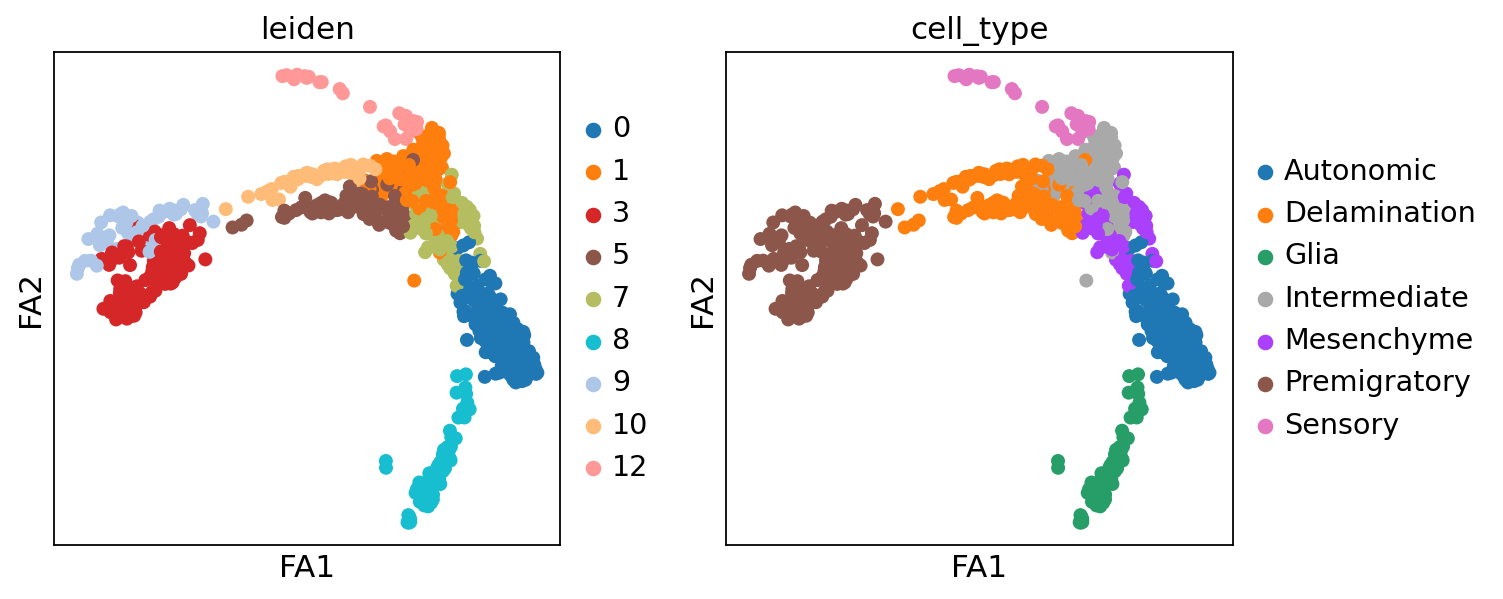

In [ ]:
sc.pl.draw_graph(adata_nccs, color=["leiden", "cell_type"])

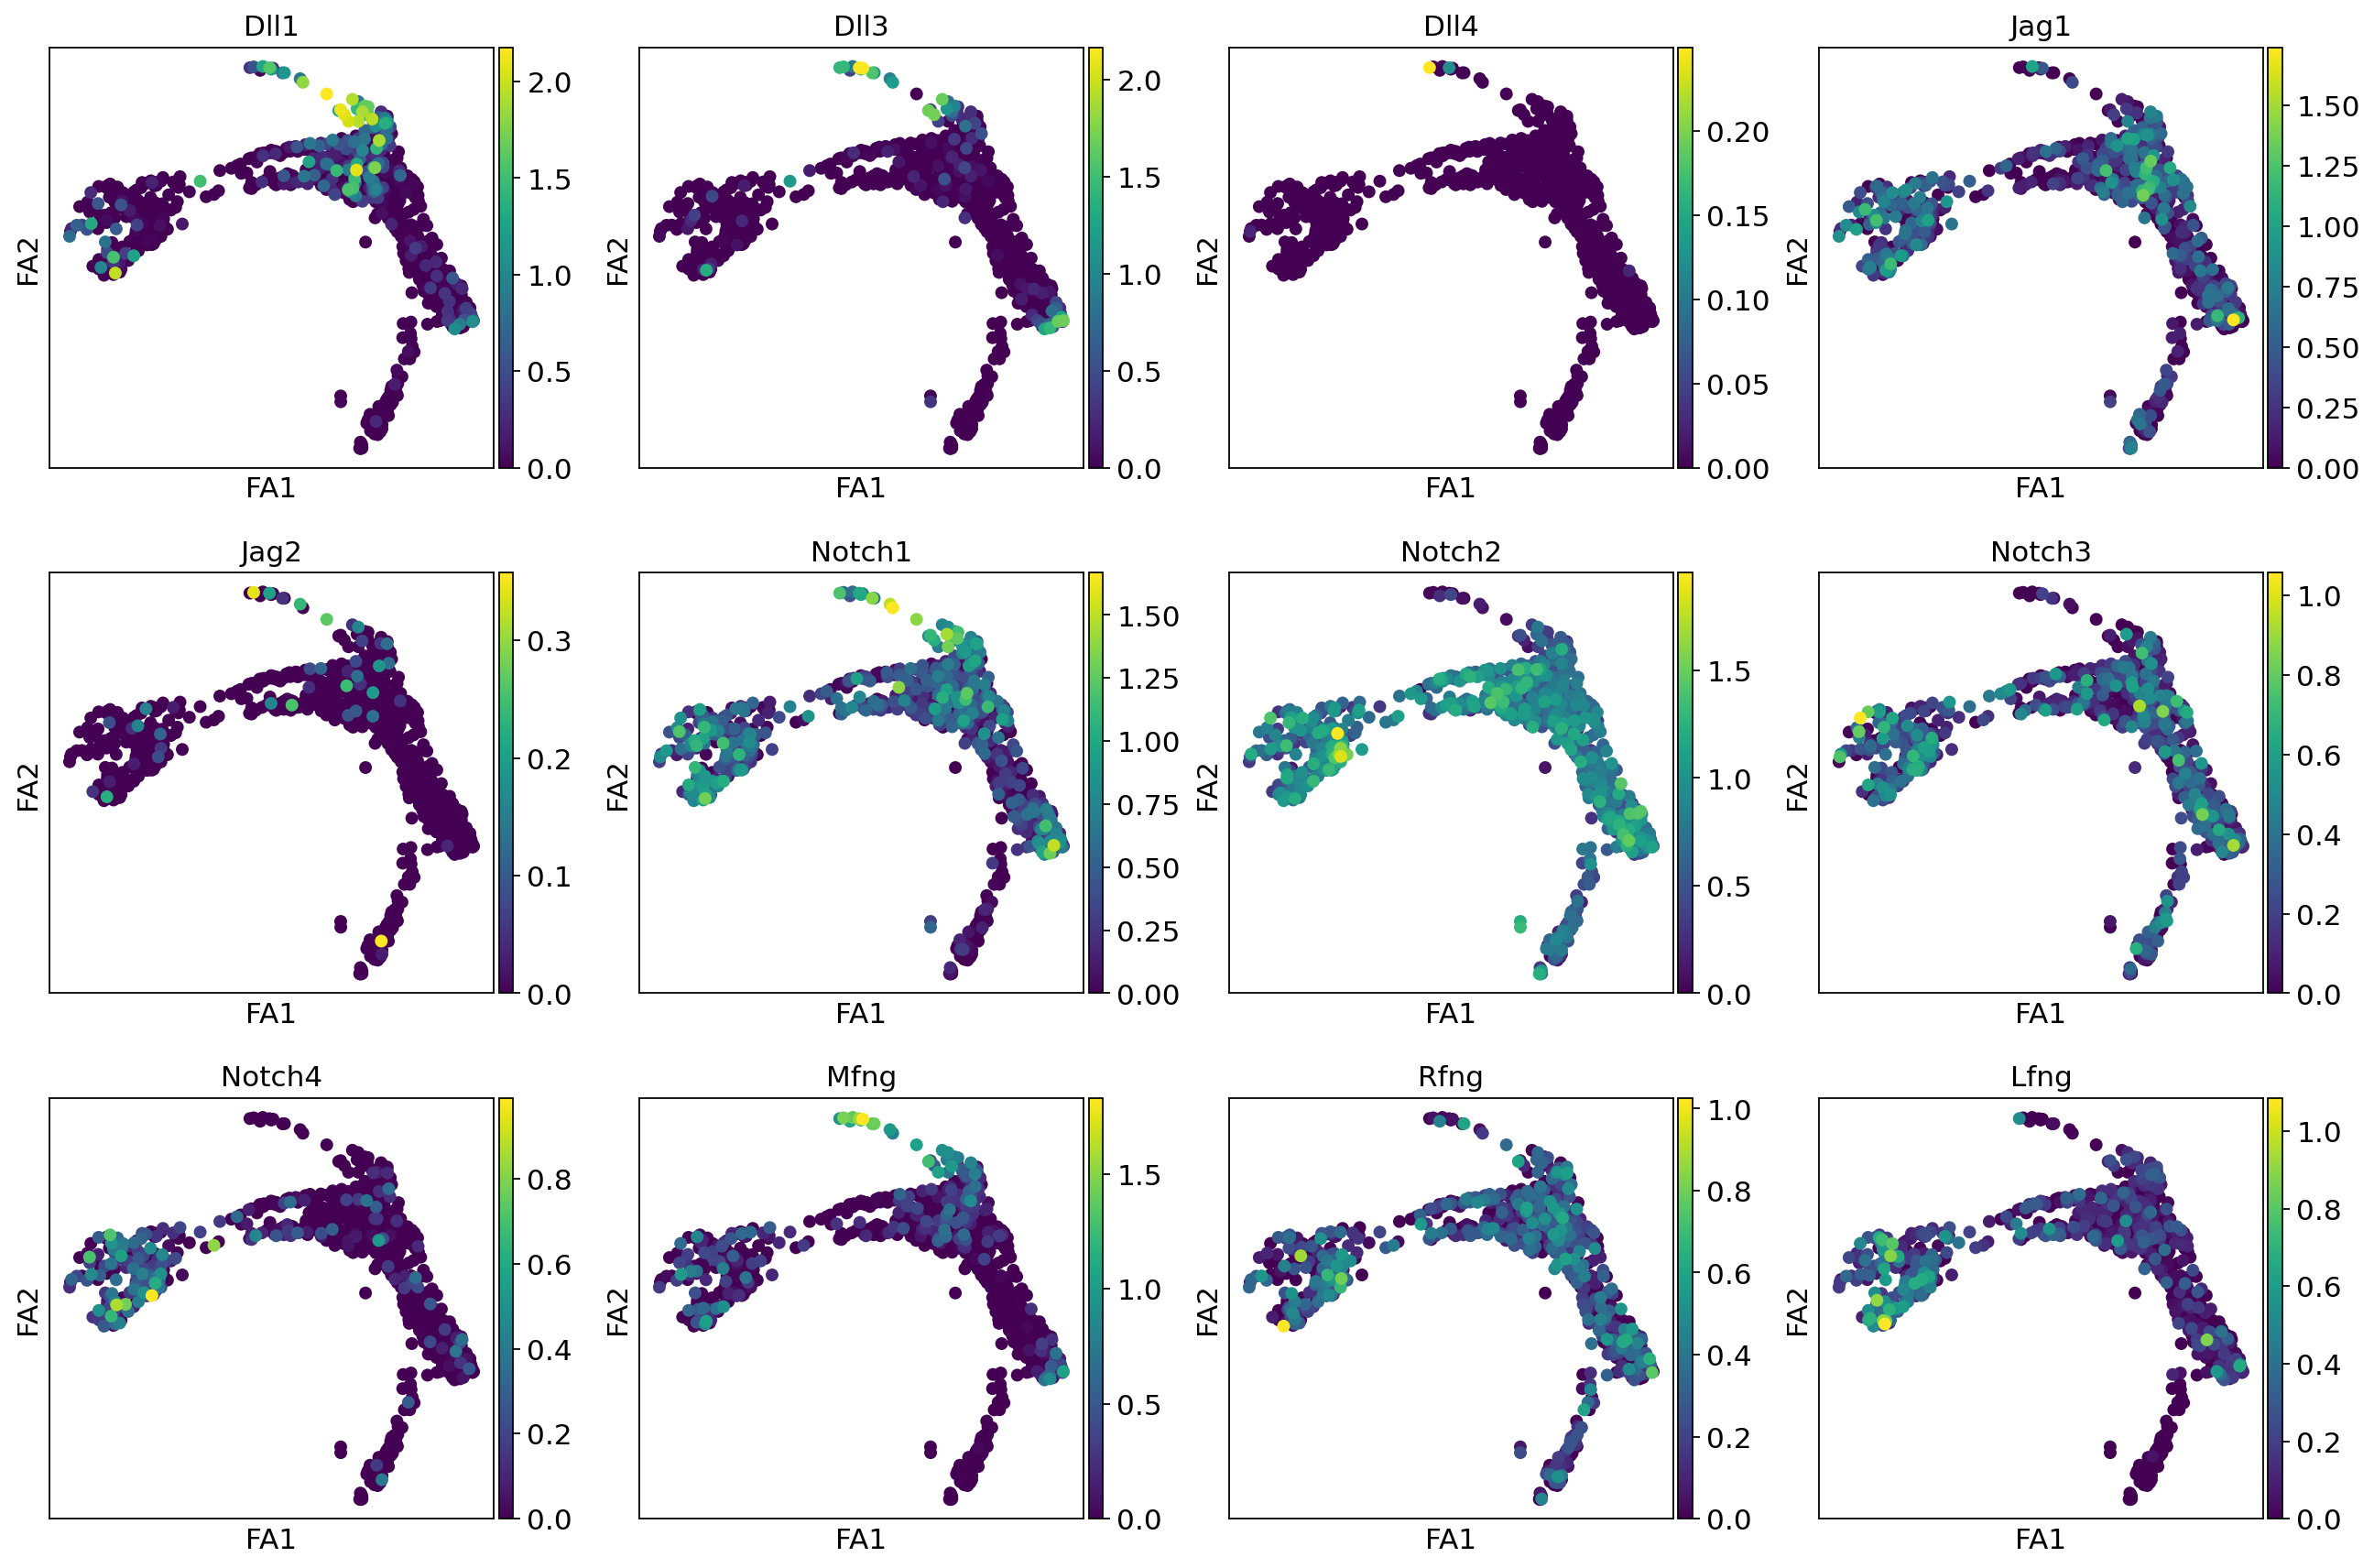

In [ ]:
sc.pl.draw_graph(adata_nccs, color=notch)

### Pseudotime Trajectory Analysis [Slingshot R] <a class="anchor" id="12-bullet"></a>

Our dimensionality reduction of the skin tissues seems to match that from the publication. We can now do pseudotime analysis on this with Slingshot, a pseudotime analysis package in R. We can pass our AnnData object into R with anndata2ri (which relies on rpy2), which makes the AnnData object a SingleCellExperiment (SCE) object in an R environment.

In [ ]:
ncc_sce = adata_nccs.copy()

del ncc_sce.uns["neighbors"]

We can do pseudotime analysis on our skin cells with Slingshot. 

Soldatov et al. uses as a root the premigratory cells, and has three branches whose endpoints are the Mesenchyme, Sensory Neurons, and Autonomic Neurons. We can match our leiden clusters on our FA representation to define these root and endpoint clusters. We will do the pseudotime analysis with the R program Slingshot. 

We send our AnnData object to R, so it is transformed to a SCE object, and do Slingshot pseudotime trajectory analysis on it.

In [ ]:
%%time
%%R -i ncc_sce

print("1:")

ncc_sling <- slingshot(ncc_sce, 
                         clusterLabels = 'leiden', 
                         reducedDim = 'X_draw_graph_fa',
                         start.clus = c("3"), 
                         end.clus = c("12", "0", "7"),
                         approx_points=100) # these clusters are the endpoints

print(SlingshotDataSet(ncc_sling))

[1] "1:"
class: SlingshotDataSet 

 Samples Dimensions
     760          2

lineages: 3 
Lineage1: 3  9  10  5  1  8  0  
Lineage2: 3  9  10  5  1  7  
Lineage3: 3  9  10  5  1  12  

curves: 3 
Curve1: Length: 7636.4	Samples: 587
Curve2: Length: 6928.3	Samples: 568.24
Curve3: Length: 6077.3	Samples: 401.17
CPU times: user 9.13 s, sys: 392 ms, total: 9.52 s
Wall time: 9.46 s


We get 3 lineages from using the FA representation. 

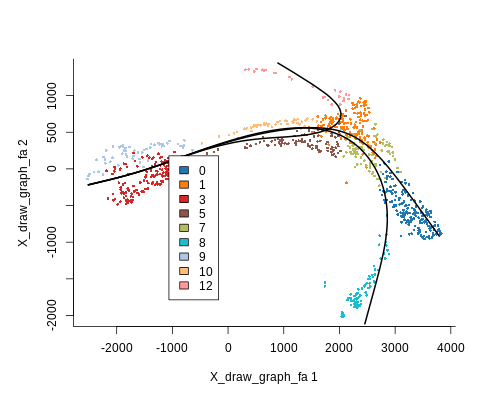

In [ ]:
%%R -w 500 -h 400 # we can plot the lineages below.

par(xpd=TRUE)
par(mar=c(5, 5, 4, 3) + 0.1)
plot(reducedDims(ncc_sce)$X_draw_graph_fa[,1], 
     reducedDims(ncc_sce)$X_draw_graph_fa[,2], 
     col=unlist(metadata(ncc_sce)$leiden_colors)[colData(ncc_sce)$leiden], 
     bty='L', xlab='X_draw_graph_fa 1', ylab='X_draw_graph_fa 2', pch=16, cex=0.5)
lines(SlingshotDataSet(ncc_sling), lwd=2)

legend("bottomleft", inset=c(0.25,0.1), legend=sort(unique(colData(ncc_sce)$leiden)), 
       fill=unlist(metadata(ncc_sce)$leiden_colors))

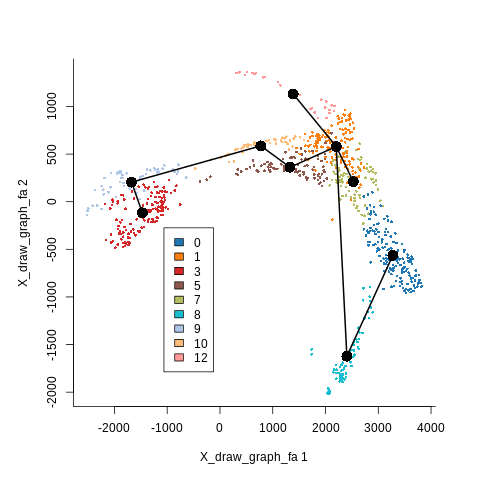

In [ ]:
%%R

par(xpd=TRUE)
par(mar=c(5, 5, 4, 3) + 0.1)
plot(reducedDims(ncc_sce)$X_draw_graph_fa[,1], 
     reducedDims(ncc_sce)$X_draw_graph_fa[,2], 
     col=unlist(metadata(ncc_sce)$leiden_colors)[colData(ncc_sce)$leiden], 
     bty='L', xlab='X_draw_graph_fa 1', ylab='X_draw_graph_fa 2', pch=16, cex=0.5)
lines(SlingshotDataSet(ncc_sling), lwd=2, type='lineages')

legend("bottomleft", inset=c(0.25,0.1), legend=sort(unique(colData(ncc_sce)$leiden)), 
       fill=unlist(metadata(ncc_sce)$leiden_colors))

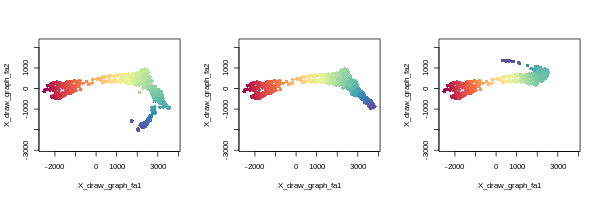

In [ ]:
%%R -w 600 -h 200

library(RColorBrewer)
par(mfrow=c(1,3))

#Plot of lineage 1
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(ncc_sling)$X_draw_graph_fa[,c(1,2)], col = colors[cut(ncc_sling$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='X_draw_graph_fa1', ylab='X_draw_graph_fa2')
lines(slingCurves(ncc_sling)$curve1, lwd=2)

#Plot of lineage 2
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(ncc_sling)$X_draw_graph_fa[,c(1,2)], col = colors[cut(ncc_sling$slingPseudotime_2,breaks=100)], pch=16, asp = 1, xlab='X_draw_graph_fa1', ylab='X_draw_graph_fa2')
lines(slingCurves(ncc_sling)$curve2, lwd=2)

#Plot of lineage 3
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(ncc_sling)$X_draw_graph_fa[,c(1,2)], col = colors[cut(ncc_sling$slingPseudotime_3,breaks=100)], pch=16, asp = 1, xlab='X_draw_graph_fa1', ylab='X_draw_graph_fa2')
lines(slingCurves(ncc_sling)$curve3, lwd=2)

To save the pseudotime values and trajectory coordinates, we can send dataframes of these values out to Python, and save them to our AnnData objects.

In [ ]:
%%R -o pt_df,traj1,traj2,traj3

# We could just pass our nephron_sling object as output from our R cell and make it a
# sce object with anndata2ri, but it's nice to have all our annotations on one object.

# We can save the pseudotime values
pt_df <- data.frame(slingPseudotime(ncc_sling, na=F))

# We can save the curve coordinates of the trajectories (for easy plotting with scanpy!)
traj <- slingCurves(ncc_sling)
traj1 <- traj$Lineage1$s
traj2 <- traj$Lineage2$s
traj3 <- traj$Lineage3$s

In [ ]:
# Add the pseudotime values as obs annotations to our scanpy object
adata_nccs.obs['slingPseudotime_1'] = pt_df['Lineage1']
adata_nccs.obs['slingPseudotime_2'] = pt_df['Lineage2']
adata_nccs.obs['slingPseudotime_3'] = pt_df['Lineage3']


# Add the curve coordinates to the scanpy object.
adata_nccs.uns['curve1'] = traj1
adata_nccs.uns['curve2'] = traj2
adata_nccs.uns['curve3'] = traj3

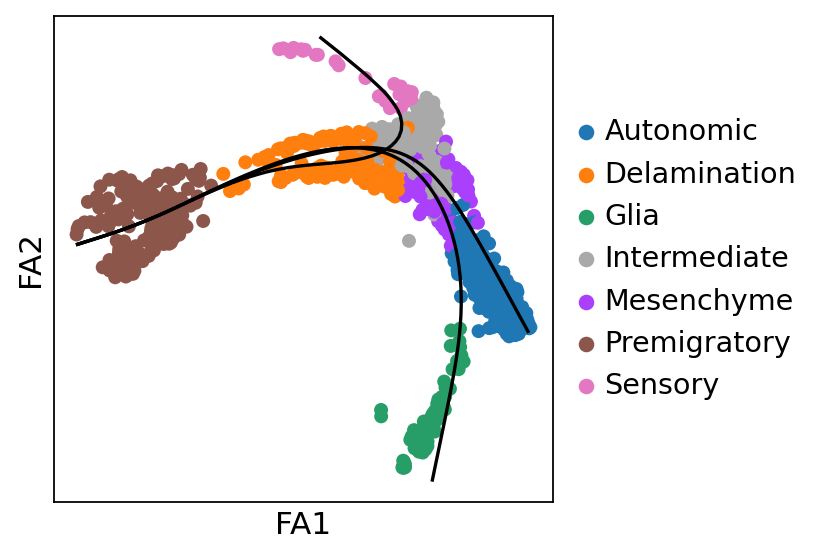

In [ ]:
fig,ax = plt.subplots()

sc.pl.draw_graph(adata_nccs, color = "cell_type", title = "", show=False, ax=ax)

ax.plot(adata_nccs.uns['curve1'][:,0], adata_nccs.uns['curve1'][:,1],color='black')
ax.plot(adata_nccs.uns['curve2'][:,0], adata_nccs.uns['curve2'][:,1],color='black');
ax.plot(adata_nccs.uns['curve3'][:,0], adata_nccs.uns['curve3'][:,1],color='black');

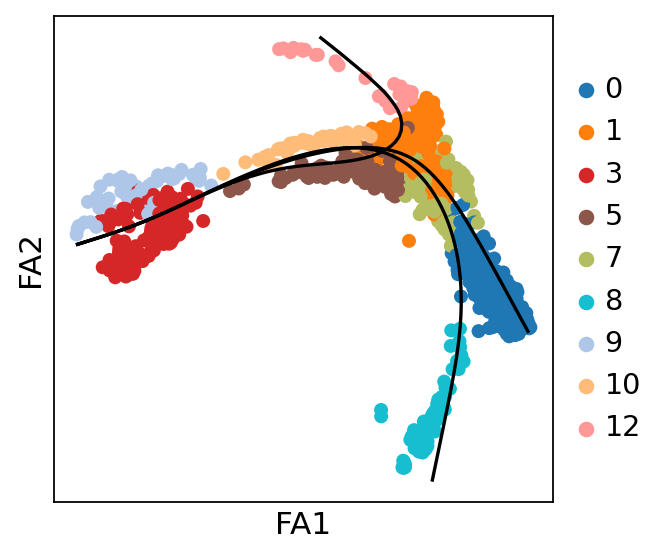

In [ ]:
fig,ax = plt.subplots()

sc.pl.draw_graph(adata_nccs, color = "leiden", title = "", show=False, ax=ax)

ax.plot(adata_nccs.uns['curve1'][:,0], adata_nccs.uns['curve1'][:,1],color='black')
ax.plot(adata_nccs.uns['curve2'][:,0], adata_nccs.uns['curve2'][:,1],color='black');
ax.plot(adata_nccs.uns['curve3'][:,0], adata_nccs.uns['curve3'][:,1],color='black');

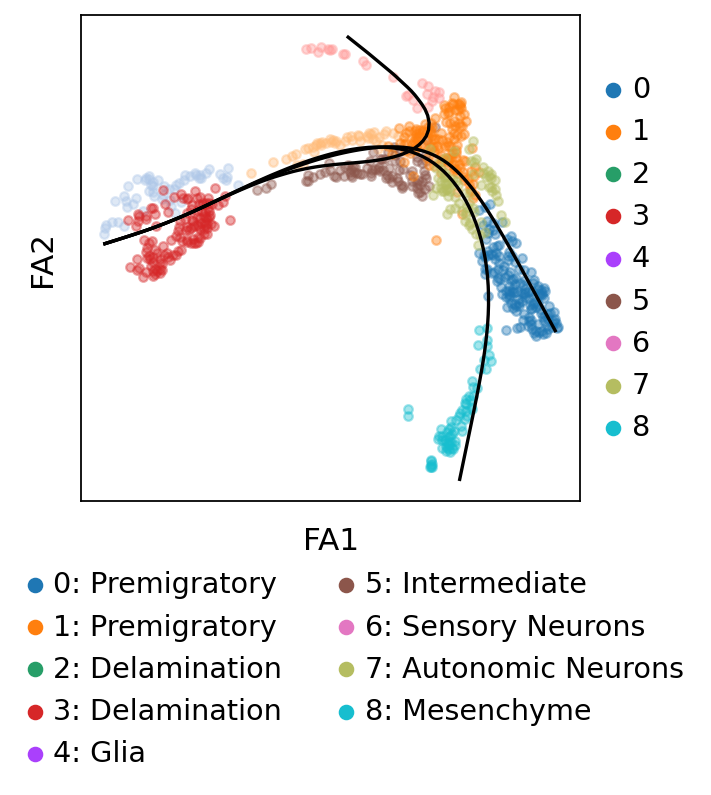

In [ ]:
fig, ax = plt.subplots()

for idx, i in enumerate(["9", "3", "10", "5", "8", "1", "12", "0", "7"]):
    subset = adata_nccs[adata_nccs.obs["leiden"] == i]
    col_idx = list(adata_nccs.obs["leiden"].cat.categories).index(i)
    ax.scatter([],[],
               label=i)
handles, labels = ax.get_legend_handles_labels()

first_legend = ax.legend(labels=["0", "1", "2", "3", "4", "5", "6", "7", "8"], 
          loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

for idx, i in enumerate(["9", "3", "10", "5", "8", "1", "12", "0", "7"]):
    subset = adata_nccs[adata_nccs.obs["leiden"] == i]
    col_idx = list(adata_nccs.obs["leiden"].cat.categories).index(i)
    ax.scatter(subset.obsm["X_draw_graph_fa"][:,0],
               subset.obsm["X_draw_graph_fa"][:,1],
               c = adata_nccs.uns["leiden_colors"][col_idx],s=15,
               label=i, alpha=0.4)

ax.add_artist(first_legend)
ax.legend(handles, labels=["0: Premigratory", "1: Premigratory", 
                           "2: Delamination", "3: Delamination", "4: Glia", "5: Intermediate", 
                           "6: Sensory Neurons", "7: Autonomic Neurons", "8: Mesenchyme"], 
          loc='lower center', bbox_to_anchor=(0.55, -0.6), frameon=False, ncol=2)

ax.grid(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel("FA1")
ax.set_ylabel("FA2")
for tic in ax.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
for tic in ax.yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
    
ax.plot(adata_nccs.uns['curve1'][:,0], adata_nccs.uns['curve1'][:,1],color='black')
ax.plot(adata_nccs.uns['curve2'][:,0], adata_nccs.uns['curve2'][:,1],color='black');
ax.plot(adata_nccs.uns['curve3'][:,0], adata_nccs.uns['curve3'][:,1],color='black');

For later integration with the atlas, we need to save the cluster-averaged log-normalized raw count data (stored in the object `pre_norm` above) for all expressed genes in the dataset. We can save this as a dataframe.

In [ ]:
pre_norm = pre_norm[adata_nccs.obs.index]

pre_norm.obs["leiden"] = adata_nccs.obs["leiden"]
pre_norm.obs["cell_type"] = adata_nccs.obs["cell_type"]

# Get the Leiden cluster labels for each AnnData object
clusters = list(pre_norm.obs['leiden'].unique())
clusters.sort()

# Initialize a DataFrame
df = pd.DataFrame(index = clusters, columns = pre_norm.var.index)

# Compute the average expression of all genes for each Leiden cluster
for cluster in clusters:
    df.loc[cluster] = pre_norm[pre_norm.obs['leiden'] == cluster][:, :].X.mean(0)

# Add metadata for each Leiden cluster (stage, cell type, tissue, and the # of cells in each cluster)
df["stage"] = ["E9.5"]*len(clusters)
df["cell_type"] = [pre_norm[pre_norm.obs["leiden"]==i].obs["cell_type"].value_counts().idxmax() for i in df.index]
df["num_cells"] = [pre_norm[pre_norm.obs["leiden"]==i].shape[0] for i in df.index]

# Save the DataFrame
df.head()

Trying to set attribute `.obs` of view, copying.


Sox17     Mrpl15      Lypla1      Tcea1     Rgs20    Atp6v1h  Oprk1  \
0        0.0  58.827816   82.986755  12.470199  0.205298  30.973511    0.0   
1   0.080882  65.507355   97.044121  13.742647  0.058824   31.30147    0.0   
10       0.0  57.659092  107.022728  15.636364  0.113636  43.204544    0.0   
12      0.24  63.880001  140.479996      15.68       0.0       48.0   0.36   
3        0.0  49.984001   86.160004     12.136     0.232     34.416  0.368   

       Rb1cc1   Fam150a   St18  ...       Hccs      Mid1 G530011O06Rik  \
0   20.145695       0.0    0.0  ...  26.801325  1.370861       0.10596   
1      14.625  0.044118    0.0  ...  32.198528  1.735294      0.198529   
10  20.931818       0.0    0.0  ...  36.045456  0.977273      0.068182   
12       19.6       0.0   3.16  ...  26.440001       3.4           0.2   
3   16.007999       0.0  0.008  ...     24.608     5.096         0.248   

       Kdm5d    Eif2s3y       Uty      Ddx3y stage     cell_type num_cells  
0   7.139073  10.642385  6.331126  12.211921  E9.5     Autonomic       151  
1   4.235294   8.794118  3.573529   8.139706  E9.5  Intermediate       136  
10  4.159091  10.863636  2.795455  12.613636  E9.5  Delamination        44  
12      1.88        2.8      9.24      10.52  E9.5       Sensory        25  
3      6.344     10.712     5.016      8.624  E9.5  Premigratory       125  

[5 rows x 15748 columns]

## Conclusion <a class="anchor" id="15-bullet"></a>

We can save all our AnnData objects with the `adata.write_h5ad()` method (not shown here).


In [ ]:
%load_ext watermark
%watermark -v -p numpy,pandas,scipy,seaborn,matplotlib,panel,anndata,scanpy,anndata2ri,rpy2

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

numpy     : 1.21.5
pandas    : 1.3.5
scipy     : 1.4.1
seaborn   : 0.11.2
matplotlib: 3.2.2
panel     : 0.12.1
anndata   : 0.7.5
scanpy    : 1.5.1
anndata2ri: 1.0.2
rpy2      : 3.3.2
jupyterlab: not installed



In [ ]:
%%R
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas/liblapack.so.3

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    tools     stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] RColorBrewer_1.1-2          slingshot_2.2.0            
 [3] TrajectoryUtils_1.2.0       SingleCellExperiment_1.16.0
 [5] SummarizedExperiment_1.24.0 Biobase_2.54.0             
 [7] GenomicRanges_1.46.1        GenomeInfoDb_1.30.1        
 [